## General imports

In [1]:
import sys 
sys.path.insert(0, "/")  # this depends on the notebook depth and must be adapted per notebook
from compert.paths import DATA_DIR, EMBEDDING_DIR

In [2]:
import numpy as np
from dgllife.utils import (
    smiles_to_bigraph,
    CanonicalAtomFeaturizer,
    CanonicalBondFeaturizer)

Using backend: pytorch


## Load Smiles list

In [3]:
dataset_name = 'lincs_trapnell'

In [4]:
import pandas as pd 
smiles_df = pd.read_csv(EMBEDDING_DIR / f'{dataset_name}.smiles')
smiles_list = smiles_df['smiles'].values

In [5]:
print(f'Number of smiles strings: {len(smiles_list)}')

Number of smiles strings: 17869


## Featurizer functions

In [6]:
node_feats = CanonicalAtomFeaturizer(atom_data_field="h")
edge_feats = CanonicalBondFeaturizer(bond_data_field="h", self_loop=True)

## Create graphs from smiles and featurizers

In [7]:
mol_graphs = []

for smiles in smiles_list: 
    mol_graphs.append(smiles_to_bigraph(
        smiles=smiles,
        add_self_loop=True,
        node_featurizer=node_feats,
        edge_featurizer=edge_feats,
    ))

In [8]:
print(f'Number of molecular graphs: {len(mol_graphs)}')

Number of molecular graphs: 17869


## Batch graphs 

In [9]:
import dgl

mol_batch = dgl.batch(mol_graphs)

In [10]:
mol_batch

Graph(num_nodes=574049, num_edges=1822023,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(13,), dtype=torch.float32)})

## Load pretrained model

Choose a model form [here](https://lifesci.dgl.ai/api/model.pretrain.html)

In [43]:
model_name = 'GCN_canonical_PCBA'
# model_name = 'MPNN_canonical_PCBA'
# model_name = 'AttentiveFP_canonical_PCBA'
# model_name = 'Weave_canonical_PCBA'
# model_name = 'GCN_Tox21'

In [44]:
from dgllife.model import load_pretrained

model = load_pretrained(model_name)

verbose=True
if verbose: 
    print(model)

Pretrained model loaded
GCNPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=74, out=128, normalization=none, activation=<function relu at 0x7f4dd90d9af0>)
        (dropout): Dropout(p=0.053320999462421345, inplace=False)
        (res_connection): Linear(in_features=74, out_features=128, bias=True)
        (bn_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GCNLayer(
        (graph_conv): GraphConv(in=128, out=128, normalization=none, activation=<function relu at 0x7f4dd90d9af0>)
        (dropout): Dropout(p=0.053320999462421345, inplace=False)
        (res_connection): Linear(in_features=128, out_features=128, bias=True)
        (bn_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_fea

## Predict with pretrained model

### Take readout, just before prediction

In [45]:
model.eval()
# no edge features 
prediction = model(mol_batch, mol_batch.ndata['h'])
# # with edge features 
# prediction = model(mol_batch, mol_batch.ndata['h'], mol_batch.edata['h'])
print(f'Prediction has shape: {prediction.shape}')
prediction

Prediction has shape: torch.Size([17869, 128])


tensor([[-1.9630, -5.2341, -4.9118,  ..., -6.0810, -3.7350, -5.7398],
        [-2.2777, -6.7303, -6.1323,  ..., -7.0724, -3.5493, -4.8586],
        [-2.1973, -6.4143, -5.9238,  ..., -6.7537, -3.0742, -4.7682],
        ...,
        [-2.5118, -5.1911, -5.3535,  ..., -5.5674, -2.7374, -2.5923],
        [-1.0887, -6.3505, -4.9517,  ..., -5.8830, -2.2948, -4.5158],
        [-1.8794, -5.3414, -5.0257,  ..., -6.3407, -4.0928, -6.3649]],
       grad_fn=<AddmmBackward>)

## Save

In [46]:
import pandas as pd
df = pd.DataFrame(data=prediction.detach().numpy(),index=smiles_list,columns=[f'latent_{i+1}' for i in range(prediction.size()[1])]) 

In [47]:
import os 

fname = f'{model_name}_embedding_{dataset_name}.parquet'

directory = EMBEDDING_DIR /'dgl' / 'data' /'embeddings'
if not directory.exists(): 
    os.makedirs(directory)
    print(f"Created folder: {directory}")

df.to_parquet(directory / fname)

Check that it worked

In [48]:
df = pd.read_parquet(directory/ fname)
df

,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,...,latent_119,latent_120,latent_121,latent_122,latent_123,latent_124,latent_125,latent_126,latent_127,latent_128
C[C@H](NC(=O)/C(C#N)=C/c1cccc(Br)n1)c1ccccc1,-1.963028,-5.234110,-4.911811,-5.473712,-7.534226,-3.644610,-3.818825,-6.634154,-5.056901,-6.984773,...,-3.967899,-6.027374,-1.986228,-0.854913,-6.273271,-5.420784,-4.036238,-6.080980,-3.734994,-5.739766
Cc1cc(Nc2cc(CN3CCOCC3)c3nc(C)c(Cc4ccc(Cl)cc4F)n3n2)[nH]n1,-2.277695,-6.730335,-6.132312,-6.088162,-8.523118,-6.373206,-5.031052,-6.659109,-5.574930,-8.196580,...,-5.501211,-6.164582,-1.545218,-1.289767,-8.601374,-6.177891,-3.907634,-7.072416,-3.549279,-4.858633
Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NCC(O)c4cccc(Cl)c4)cc[nH]c3=O)nc12,-2.197271,-6.414289,-5.923784,-5.658588,-8.051690,-5.850062,-4.908119,-6.203526,-5.164637,-7.895138,...,-5.147470,-5.771419,-1.500738,-1.163054,-8.232834,-5.853126,-3.729787,-6.753736,-3.074219,-4.768165
Cl.Cl.c1ccc([C@@H]2C[C@H]2NC2CCNCC2)cc1,-2.634433,-5.812743,-5.727026,-6.064070,-8.413697,-5.238608,-4.935480,-7.220577,-5.669816,-7.415796,...,-4.581165,-6.764301,-2.460679,-0.707918,-7.418577,-6.131401,-4.327480,-6.822812,-4.405416,-5.821548
O=C(c1ccc(/C=C/c2n[nH]c3ccccc23)cc1)N1CCNCC1,-2.255028,-5.005852,-5.194728,-5.342830,-7.475539,-3.844177,-3.387102,-6.491154,-4.582006,-7.000909,...,-3.849707,-4.934171,-2.056653,-1.352311,-6.772676,-5.288044,-3.925443,-5.785974,-3.527073,-4.024390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCC(=O)Nc1ccc2c(c1)C(=O)N(C)C[C@H](OC)[C@@H](C)CN(Cc1ccc(-c3ccccn3)cc1)[C@@H](C)CO2,-2.022467,-6.688183,-5.659212,-4.920155,-7.623466,-6.563124,-4.908202,-5.021143,-4.856961,-7.617170,...,-5.138133,-5.191879,-1.824486,-0.699281,-8.474396,-5.554111,-3.387792,-6.549770,-2.369574,-4.105406
Cc1cc(CS(=O)(=O)c2ccccc2)cc(OCc2ccc(CN3CCC[C@@H]3CO)cc2)c1,-2.250377,-6.373003,-5.865250,-5.382934,-7.931846,-5.927632,-5.072748,-5.825402,-5.054090,-7.731327,...,-4.820147,-5.371975,-1.955942,-1.158019,-8.347329,-5.745896,-3.668715,-6.515472,-2.881742,-4.178917
CN(C)CCOc1ccc(/C(=C(\CCCl)c2ccccc2)c2ccccc2)cc1,-2.511837,-5.191076,-5.353533,-4.976253,-7.390970,-4.114701,-4.154357,-5.871979,-4.368958,-7.211859,...,-3.795351,-3.883182,-2.260992,-1.867181,-7.532574,-5.170040,-3.710196,-5.567438,-2.737440,-2.592287
CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C3=C[C@@]34NC(=O)[C@]5(CCCN5C3=O)C[C@H]4C2(C)C)O1,-1.088698,-6.350516,-4.951694,-4.444723,-6.811122,-6.434884,-3.217741,-4.498516,-4.340159,-6.513362,...,-4.841718,-5.208997,-2.125300,-0.060484,-7.615060,-4.965421,-3.137559,-5.883044,-2.294752,-4.515803


In [49]:
df.std()

latent_1      0.363141
latent_2      0.859743
latent_3      0.528936
latent_4      0.635845
latent_5      0.664787
                ...   
latent_124    0.530052
latent_125    0.423587
latent_126    0.631603
latent_127    0.783461
latent_128    0.947517
Length: 128, dtype: float32

## Drawing molecules

In [41]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw

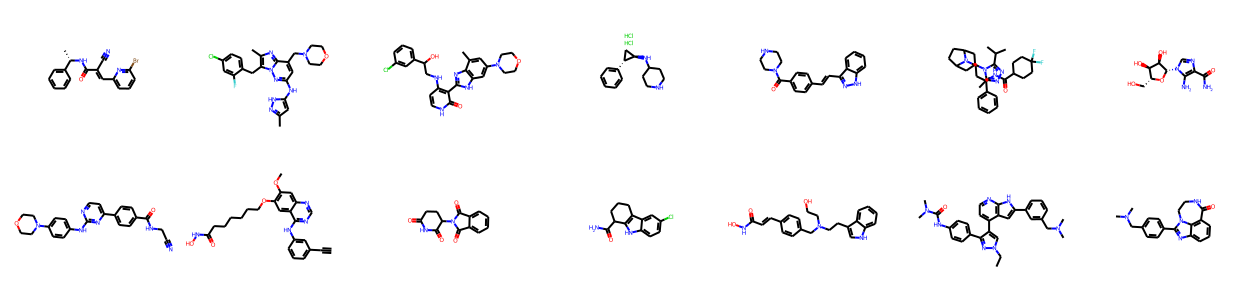

In [42]:
mols = [Chem.MolFromSmiles(s) for s in smiles_list[:14]]
Draw.MolsToGridImage(mols, molsPerRow=7, subImgSize=(180, 150))